## Import Libraries

In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from PIL import Image, ImageOps, ImageEnhance
from tensorflow.keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from skimage.transform import resize 
import keras.utils as ku
import random

## Read images and transform the data

In [2]:

#* setting absolute path  for the project as base_dir
base_dir = os.path.abspath('.')
#* collecting data
original_img_dir = Path(base_dir,'TrashType_Image_Dataset')
transformer = T.Compose([T.Resize((32,32)), T.ToTensor()])
dataset = ImageFolder(original_img_dir, transform= transformer)

print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## distribution of files by class

d:\programs\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


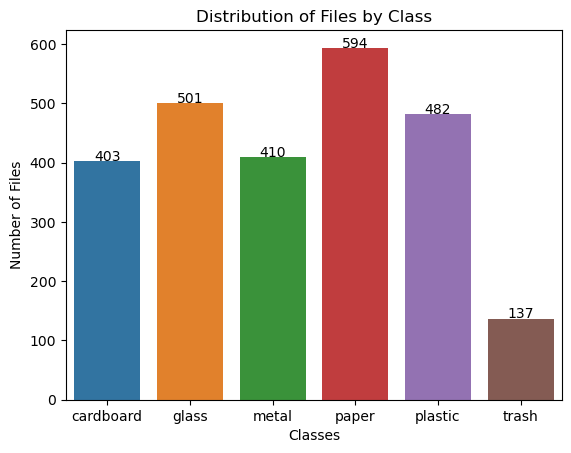

In [3]:
def count_files(directory):
    """
    This function takes a directory path as input and returns the number of files in that directory.
    """
    only_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(only_files)

classes_and_count = {}
# Example usage:
for claass in dataset.classes:
    directory = Path(original_img_dir, claass)
    classes_and_count[claass] = count_files(directory)
sns.barplot(x=list(classes_and_count.keys()), y=list(classes_and_count.values()))
plt.xlabel('Classes')
plt.ylabel('Number of Files')
plt.title('Distribution of Files by Class')
for i, v in enumerate(classes_and_count.values()):
    plt.text(i, v+0.5, str(v), ha='center')

plt.show()

## split and store the data into train and test data

In [4]:

#* generating gray and resized images
for claass in dataset.classes:
    image_path_org = Path(base_dir,'TrashType_Image_Dataset', claass)
    image_path_gray = Path(base_dir,'processed trashtype_image_dataset',claass)
    list_files = os.listdir(image_path_org)
    for file in list_files:
        read_img = Image.open(os.path.join(image_path_org, file))
        img = read_img.resize((32,32))
        gray = img.convert('L')
        gray.save(os.path.join(image_path_gray, file), "JPEG")

In [5]:

#* entering train nad test directories path in variables
train_dir = os.path.join(base_dir, 'processed trashtype_image_dataset')
test_dir = os.path.join(base_dir, 'TrashType_Image_Dataset')

In [6]:

#* it can easily transform the image to range from range 0,255 to 0,1
image_gen = ImageDataGenerator(rescale=1./255)

train_data_gen = image_gen.flow_from_directory(
    directory = train_dir, 
    shuffle=True, 
    target_size = (32, 32),
    class_mode='categorical')

test_data_gen = image_gen.flow_from_directory(
    directory = test_dir, 
    shuffle=True, 
    target_size = (32, 32),
    class_mode='categorical')

Found 2527 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.


## Builing the Neural Network

In [7]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32,32, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(6, activation='softmax')
])

## setting up training parameters

In [8]:
batch_size = 45
epochs = 60
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          

In [9]:
num_cardboard_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'cardboard')))
num_glass_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'glass')))
num_metal_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'metal')))
num_paper_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'paper')))
num_plastic_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'plastic')))
num_trash_train = len(os.listdir(Path(base_dir,'TrashType_Image_Dataset', 'trash')))

num_cardboard_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'cardboard')))
num_glass_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'glass')))
num_metal_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'metal')))
num_paper_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'paper')))
num_plastic_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'plastic')))
num_trash_test = len(os.listdir(Path(base_dir, 'processed trashtype_image_dataset', 'trash')))

total_train = sum((num_cardboard_train , num_glass_train , num_metal_train , num_paper_train , num_plastic_train , num_trash_train))
total_test = sum((num_cardboard_test , num_glass_test , num_metal_test , num_paper_test , num_plastic_test , num_trash_test))

print(total_test, total_train)

2527 2527


In [10]:
history = model.fit(
    train_data_gen,
    validation_data = train_data_gen,
    steps_per_epoch= total_train // batch_size,
    epochs = epochs,
    validation_steps= total_test // batch_size,
    callbacks = [tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.01,
                patience=7)]
)

Epoch 1/60


56/56 [==============================] - 13s 170ms/step - loss: 1.7288 - accuracy: 0.2221 - val_loss: 1.7019 - val_accuracy: 0.2946
Epoch 2/60
56/56 [==============================] - 2s 33ms/step - loss: 1.6561 - accuracy: 0.2824 - val_loss: 1.5786 - val_accuracy: 0.2924
Epoch 3/60
56/56 [==============================] - 1s 25ms/step - loss: 1.5684 - accuracy: 0.3328 - val_loss: 1.4874 - val_accuracy: 0.3817
Epoch 4/60
56/56 [==============================] - 1s 24ms/step - loss: 1.4804 - accuracy: 0.3953 - val_loss: 1.4482 - val_accuracy: 0.4325
Epoch 5/60
56/56 [==============================] - 1s 25ms/step - loss: 1.4269 - accuracy: 0.4333 - val_loss: 1.4659 - val_accuracy: 0.4163
Epoch 6/60
56/56 [==============================] - 5s 86ms/step - loss: 1.3711 - accuracy: 0.4551 - val_loss: 1.3795 - val_accuracy: 0.4565
Epoch 7/60
56/56 [==============================] - 6s 106ms/step - loss: 1.3378 - accuracy: 0.4712 - val_loss: 1.3010 - val_accuracy: 0.5017
Epoch 8/

In [11]:
test_loss, test_acc = model.evaluate(test_data_gen)
print(f'Test accuracy: {test_acc*100}, Test Loss: {test_loss}')

79/79 [==============================] - 12s 149ms/step - loss: 0.5836 - accuracy: 0.8287
Test accuracy: 82.86505937576294, Test Loss: 0.5836007595062256


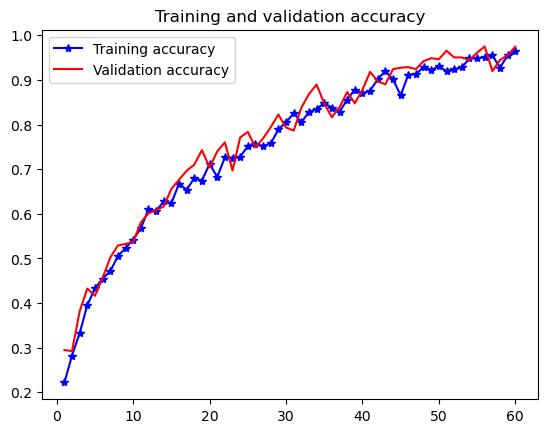

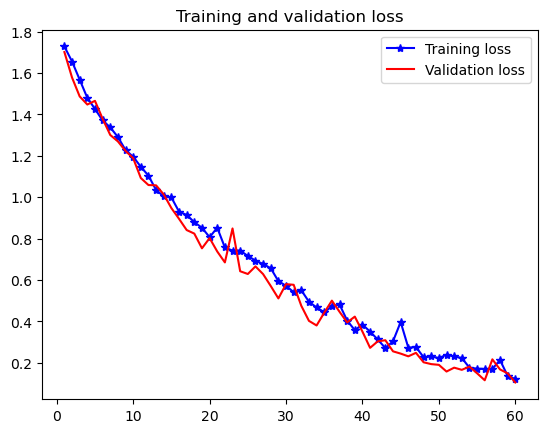

In [17]:
train_acc = history.history['accuracy'] # store training accuracy in history
val_acc = history.history['val_accuracy'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Testing prediction

1/1 [==============================] - 0s 36ms/step
Glass picture number : 205
Truth : glass
Probability: 57.08088278770447 %
Classified: glass 



Text(0.5, 1.0, 'Loaded Image')

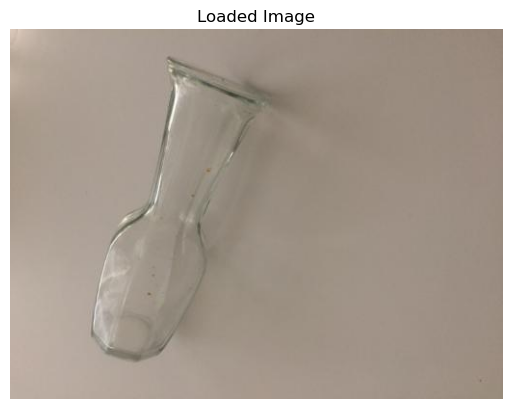

In [135]:
random_class = random.choice(dataset.classes)
random_num = random.randint(0, classes_and_count[random_class])
random_num_str = str(random_num).zfill(3)

test_img_path = Path(base_dir,'TrashType_Image_Dataset',random_class)
test_img = f'{test_img_path}\{random_class}_{random_num_str}.jpg'
show_img = ku.load_img(test_img)
img = ku.load_img(test_img, target_size = (32,32))
img = ku.img_to_array(img, dtype=np.uint8)
img = np.array(img)/255.0
prediction = model.predict(img[np.newaxis,...])

#print("Predicted shape",p.shape)
print(f"{random_class.title()} picture number : {random_num}")
print(f"Truth : {random_class}")
print("Probability: {:.2f}%".format(np.max(prediction[0], axis=-1) * 100))
predicted_class = dataset.classes[np.argmax(prediction[0], axis=-1)]
print("Classified:",predicted_class,'\n')

plt.axis('off')
plt.imshow(show_img)
plt.title("Loaded Image")